<a href="https://colab.research.google.com/github/dominiquebuford/AIPI540-project1/blob/dombuford/detectron2_naive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#make sure I am using GPU
!nvidia-smi

Sat Jan 27 17:22:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Colab has cuda 11.1 pre-installed nowadays, downgrading to 1.9 for detectron2
!pip install -U torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U pycocotools
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.9.0+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
#install detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-wibbsjc0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-wibbsjc0
  Resolved https://github.com/facebookresearch/detectron2.git to commit b7ff9466d174fbb7061ff6d3773cd9c372a8e56f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6119666 sha256=ef2432d01621f0e9d3be51a8aeb

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import json
from tqdm.notebook import tqdm

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# For reading annotations file
from pycocotools.coco import COCO

# utilities
from pprint import pprint # For beautiful print!
from collections import OrderedDict
import os

# For data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from google.colab.patches import cv2_imshow

In [ ]:
# Reading annotations.json
TRAIN_ANNOTATIONS_PATH = "/content/data/train/extracted_images/annotations.json"
TRAIN_IMAGE_DIRECTORY = "/content/data/train/extracted_images/images/"

VAL_ANNOTATIONS_PATH = "/content/data/val/extracted_images/annotations.json"
VAL_IMAGE_DIRECTORY = "/content/data/val/extracted_images/images/"

train_coco = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=4.12s)
creating index...
index created!


In [ ]:
# Reading the annotation files
with open(TRAIN_ANNOTATIONS_PATH) as f:
  train_annotations_data = json.load(f)

with open(VAL_ANNOTATIONS_PATH) as f:
  val_annotations_data = json.load(f)

In [ ]:
# Reading all classes
category_ids = train_coco.loadCats(train_coco.getCatIds())
category_names = [_["name_readable"] for _ in category_ids]

print("## Categories\n-", "\n- ".join(category_names))

In [ ]:
#create a Panda's dataframe of all the images in the training annotations json file
img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds()))
img_info.head



<bound method NDFrame.head of            id   file_name  width  height
0      131094  131094.jpg    480     480
1      131097  131097.jpg    391     390
2      131098  131098.jpg    391     390
3      131100  131100.jpg    391     390
4      131101  131101.jpg    391     390
...       ...         ...    ...     ...
39957  131017  131017.jpg    480     480
39958  131021  131021.jpg    464     464
39959  131053  131053.jpg    391     390
39960  131066  131066.jpg    464     464
39961  131071  131071.jpg    464     464

[39962 rows x 4 columns]>

In [ ]:
#move folder from Drive to colab

#!cp -r '/content/drive/MyDrive/Masters-2/Deep Learning/Group Project 1 - CV/data' '/content/'


In [ ]:
#code no longer necessary after grabbing 2.0
#img_info = pd.DataFrame()

# Iterate through filenames in the DataFrame column
#for filename_to_check in img_info_precursor['file_name']:
    # Create the full path to the file in Google Drive
    #file_path = os.path.join('/content/drive/MyDrive/Masters-2/Deep Learning/Group Project 1 - CV/data/train/extracted_images/images/', filename_to_check)

    # Check if the file exists
    #if os.path.exists(file_path):
        # If the file exists, append the row to the filtered DataFrame
        #img_info = img_info.append(img_info_precursor[img_info_precursor['file_name'] == filename_to_check], ignore_index=True)


<ipython-input-21-63ab54776258>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  img_info = img_info.append(img_info_precursor[img_info_precursor['file_name'] == filename_to_check], ignore_index=True)


In [ ]:
# To grab the second tar file
#tar_path = '/content/drive/MyDrive/Masters-2/Deep Learning/Group Project 1 - CV/data/train/public_training_set_release_2.0.tar.gz'

# Define the path where you want to extract the images for the training set
#extraction_path_train = '/content/drive/MyDrive/Masters-2/Deep Learning/Group Project 1 - CV/data/train/extracted_images'

# Create the directory for the training set if it doesn't exist
#if not os.path.exists(extraction_path_train):
    #os.makedirs(extraction_path_train)

# Extract the .tar file using the tar command without gzip option
#!tar -xvf '{tar_path}' -C '{extraction_path_train}'

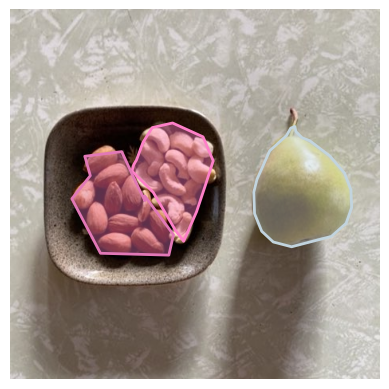

In [ ]:
#example of what an image and its annotations look like
img_no = 7

annIds = train_coco.getAnnIds(imgIds=train_annotations_data['images'][img_no]['id'])
anns = train_coco.loadAnns(annIds)

# load and render the image
plt.imshow(plt.imread(TRAIN_IMAGE_DIRECTORY+train_annotations_data['images'][img_no]['file_name']))
plt.axis('off')
# Render annotations on top of the image
train_coco.showAnns(anns)

In [ ]:
#fix any discrepancies in the image annotation sizes and actual image sizes:

def fix_data(annotations, directory):
  for n, i in enumerate(tqdm((annotations['images']))):

      img = cv2.imread(directory+i["file_name"])
      if img.shape[0] != i['height']:
          annotations['images'][n]['height'] = img.shape[0]

      if img.shape[1] != i['width']:
          annotations['images'][n]['width'] = img.shape[1]

  return annotations

train_annotations_data = fix_data(train_annotations_data, TRAIN_IMAGE_DIRECTORY)

with open('data/train/new_ann.json', 'w') as f:
    json.dump(train_annotations_data, f)

  0%|          | 0/39962 [00:00<?, ?it/s]

In [ ]:
#fix any discrepancies in the image annotation sizes and actual image sizes:

def fix_data_val(annotations, directiory):
  for n, i in enumerate(tqdm((annotations['images']))):
      img = cv2.imread(directiory+i["file_name"])
      if img.shape[0] != i['height']:
          annotations['images'][n]['height'] = img.shape[0]

      if img.shape[1] != i['width']:
          annotations['images'][n]['width'] = img.shape[1]

  return annotations

val_annotations_data = fix_data_val(val_annotations_data, VAL_IMAGE_DIRECTORY)

with open('data/val/extracted_images/new_ann.json', 'w') as f:
    json.dump(val_annotations_data, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
#load in the validation dataset to work with the naive model

#train_annotations_path = 'data/train/extracted_images_new_ann.json'
#train_images_path = 'data/train/extracted_images/images'

val_annotations_path = 'data/val/extracted_images/new_ann.json'
val_images_path = 'data/val/extracted_images/images'

In [ ]:
#register validation dataset
register_coco_instances("validation_dataset", {},val_annotations_path, val_images_path)


In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

[01/27 19:43:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:04, 38.4MB/s]                           


In [ ]:
dataset_name = "validation_dataset"
dataset_metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=dataset_metadata, scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2.waitKey(0)